In [23]:
from numpy import*
from pylab import*
import matplotlib.pyplot as plt
from h5py import File

#STIXGeneral

font = {'family' : 'STIXGeneral',
        'weight' : 'normal',
        'size'   : 22}

matplotlib.rc('font', **font)

## Accessing data

In [24]:
f = open('dict.txt','r')
data=f.read()
f.close()
data = eval(data)

In [25]:
print(data.keys()) # different values of injected mean photon population, these are the labels

dict_keys([0.08225683961245896, 0.36751853849630745, 0.01135324397826302, 0.007236769272169664, 0.004057906940956875, 0.028202605718902044, 0.001799469308404296, 5.826865227195515e-06, 0.017782789719525745, 0.01228339687027276, 0.0005649913217647377, 2.7708854882465167e-07, 0.0, 4.849147669242333e-05])


<function matplotlib.pyplot.tight_layout>

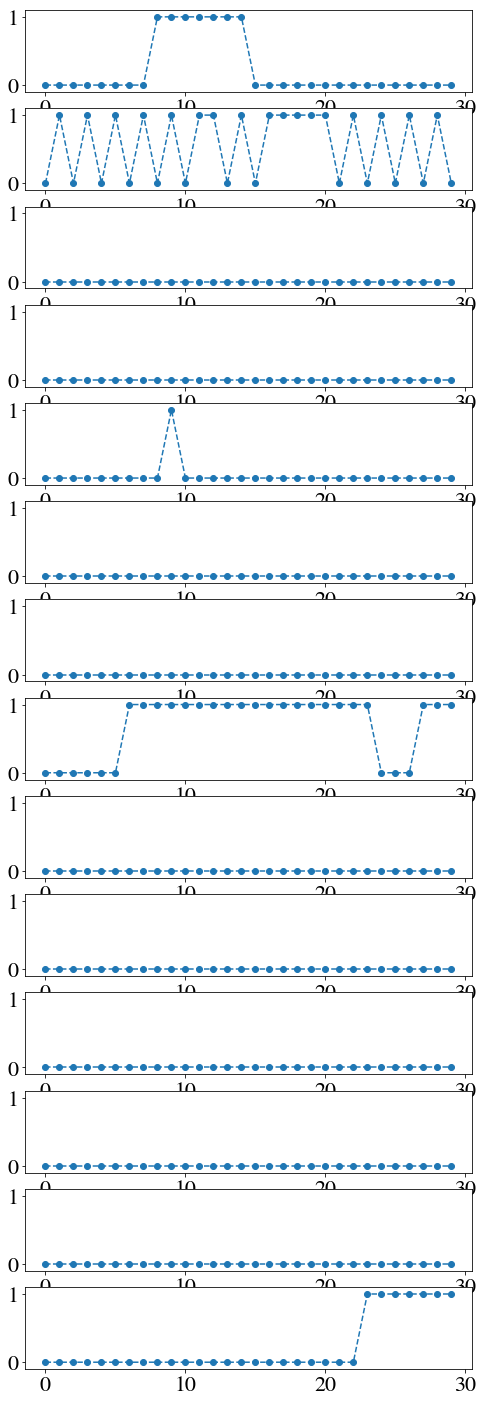

In [26]:
# Access data with a key. For each key there are a series of measurement sequences
# corresponding to the result of 30 repeated parity experiments
# Possible values for the parity expt are {0,1} representing the qubit ground and excited states

# Warning: The number of measurements sequences for each label is not the same!
# I had to perform more experiments when the probability of seeing a photon is smaller

# plotting the 14th measurmement for each injected population. nothing special about this, just an example


n_plots = len(data.keys())
figure(figsize=(8,25))

for ii,n in enumerate(data):
    subplot(n_plots, 1, ii+1)
    ylim(-0.1,1.1)
    plot(data[n][14], 'o--')
    
tight_layout

## Hidden Markov model

In [27]:
# device parameters

trigger_period = 10 # all times in micro seconds
parity_time = 0.380
cav_t1 = 545.8 # caviy decay time
qubit_t1 = 108.65 # qubit decay time
qubit_t2 = 60.67 # qubit dephasing time
# cav_n = 7.3e-4
cav_n= 0.0
qubit_n = 5.07e-2 # residual qubit population
g_infidelity = 1-0.958 # infidelity of qubit g readout
e_infidelity = 1-0.953 # infidelity of qubit e readout
parity_err = 0

In [103]:
# Defining transition and emission matricies for the hidden Markov model (HMM)

P01 = cav_n * (1-exp(-trigger_period/cav_t1))
P10 = 1-exp(-trigger_period/cav_t1)
Pge = qubit_n * (1-exp(-trigger_period/qubit_t1)) + (1-exp(-parity_time/qubit_t2)) + parity_err
Peg = (1-exp(-trigger_period/qubit_t1)) + (1-exp(-parity_time/qubit_t2)) + parity_err

T = asarray([[(1-P01)*(1-Pge), (1-P01)*Pge, P01*Pge, P01*(1-Pge)],
     [(1-P01)*Peg, (1-P01)*(1-Peg), P01*(1-Peg), P01*Peg],
     [P10*(1-Pge), P10*Pge, (1-P10)*Pge, (1-P10)*(1-Pge)],
     [P10*Peg, P10*(1-Peg), (1-P10)*(1-Peg), (1-P10)*Peg]])

E = 0.5*asarray([[1-g_infidelity, g_infidelity],
    [e_infidelity, 1- e_infidelity],
    [1-g_infidelity, g_infidelity],
    [e_infidelity, 1- e_infidelity]])

print(T)
print(E)

[[9.89298126e-01 1.07018745e-02 0.00000000e+00 0.00000000e+00]
 [9.41739263e-02 9.05826074e-01 0.00000000e+00 0.00000000e+00]
 [1.79606155e-02 1.94291536e-04 1.05075829e-02 9.71337510e-01]
 [1.70971888e-03 1.64451882e-02 8.89380886e-01 9.24642074e-02]]
[[0.479  0.021 ]
 [0.0235 0.4765]
 [0.479  0.021 ]
 [0.0235 0.4765]]


In [104]:
# State reconstrution algorithms for the HMM

# probability of possible state at i-th time step given all previous measurements
def forward(meas_seq, T, E):
        num_meas = len(meas_seq)
        N = T.shape[0]
        alpha = zeros((num_meas, N))
        pi = [0.25,0.25,0.25,0.25] # assume flat prior
        alpha[0] = pi*E[:,meas_seq[0]]
        for t in range(1, num_meas):
            alpha[t] = alpha[t-1].dot(T) * E[:, meas_seq[t]]
        return alpha

# probability of future measurements given state at i-th time step
def backward(meas_seq, T, E):
        N = T.shape[0]
        num_meas = len(meas_seq)

        beta = zeros((N,num_meas))
        beta[:,-1:] = 1

        for t in reversed(range(num_meas-1)):
            for n in range(N):
                beta[n,t] = sum(beta[:,t+1] * T[n,:] * E[:, meas_seq[t+1]])

        return beta
    
def likelihood(meas_seq, T, E):
        # returns log P(Y  \mid  model)
        # using the forward part of the forward-backward algorithm
        return  forward(meas_seq, T, E)[-1].sum()

# product of forward and backward probabilities
# probability of state at i-th time step given the entire measurement record
def gamma(meas_seq,T,E):
    alpha = forward(meas_seq, T, E)
    beta  = backward(meas_seq, T, E)
    obs_prob = likelihood(meas_seq, T, E)
    return (multiply(alpha,beta.T) / obs_prob)

# returns the most likely state seqeunce given the measurement record
# not used in this work
def viterbi(meas_seq, T, E):
        # returns the most likely state sequence given observed sequence
        # using the Viterbi algorithm
        num_meas = len(meas_seq)
        N = T.shape[0]
        delta = zeros((num_meas, N))
        psi = zeros((num_meas, N))
        pi = [0.25,0.25,0.25,0.25]
        delta[0] = pi*E[:,meas_seq[0]]
        for t in range(1, num_meas):
            for j in range(N):
                delta[t,j] = max(delta[t-1]*T[:,j]) * E[j, meas_seq[t]]
                psi[t,j] = argmax(delta[t-1]*T[:,j])

        # backtrack
        states = zeros(num_meas, dtype=int32)
        states[num_meas-1] = argmax(delta[num_meas-1])
        for t in range(num_meas-2, -1, -1):
            states[t] = psi[t+1, states[t+1]]
        return states

## Example of the HMM reconstruction in action

In [ ]:
meas_sequence = data[list(data.keys())[1]][14]

# want to compute the probabilities of 0 or 1 photon initially in the cavity
P0_first = []
P1_first = []

# iteratively calculate probabilities using one additional measurement at a time
# observe how probabilities 'evolve' with more meaurements in the recrod
for ii in range (len(meas_sequence)):
    
    # analyze subeset of measurment record from beginning to ii-th measuement
    # could be implemented online to do feedback in the measurement
    temp_meas_sequence = meas_sequence[0:ii+1]
    
    # forward-backward algorithm return state probabilities at each step
    gamma_matrix = gamma(temp_meas_sequence, T, E)
    
    # pick off probability of cavitiy state at the beginning, 0 in the first index
    # sum over qubit state probability, second index
    P0_first.append(gamma_matrix[0,0] + gamma_matrix[0,1])
    P1_first.append(gamma_matrix[0,2] + gamma_matrix[0,3])

figure(figsize = (12,8))

# plot measurement record
subplot(2,1,1)
plot(meas_sequence, 'o--')
ylim(-0.1, 1.1)

# plot reconstructed probabilities for subsets of the measurement record
subplot(2,1,2)
semilogy(P0_first, 'o', label= "P(n=0)")
semilogy(P1_first, 'o', label= "P(n=1)")
#         axhline(1e-9)
#         plot(P0_first, 'o', label= "P(n=0)")
#         plot(P1_first, 'o', label= "P(n=1)")
#         axhline(1e-8)
#         ylim(1e-16,1e0)
ylabel('P(t=0)')
xlabel('Number of Parity Measurements Included')
legend()
tight_layout

## Analyzing dataset

In [106]:
# Use the HMM to determine the likelihood that a measurement sequence
# is the result of a cavity photon present in the beginning

start = 0
stop = 30

state_dict = data

# threshold_list = [2,10,20,1e2,4e2,1e3,1e4,4e4,1e5,4e5,1e6,4e6,1e7,4e7,1e8,1e9]
# threshold_list = [1,2,5,10,20,1e2,2e2,4e2,7e2,1e3,2e3,7e3,1e4,2e4,4e4,1e5]
# threshold_list = [500,800,1000,1200,1300,1400,1500,1800,2000,10000]
# threshold_list = [1e5,1e6,1e7,1e8,1e9]
threshold_list = [1e5] # likehood threshold above which, an event is considered a detection

first_count_dict_list = []
meas_num_dict_list = []
for thresh in threshold_list:
    first_count_dict = {}
    meas_num_dict = {}
    for p1 in state_dict:
        state_list = state_dict[p1]
        meas_num_dict[p1] = len(state_list)
        first_detected_state_list = []
        max_L = []
        for ii in range (len(state_list)):
            meas_seq = state_list[ii][start:stop]
            gamma_matrix = gamma(meas_seq, T, E)

            P0 = gamma_matrix[0,0] + gamma_matrix[0,1]
            P1 = gamma_matrix[0,2] + gamma_matrix[0,3]

            # Compare the probabilities of the two models to obtain a likelihood ratio
            likelihood_ratio = P1/P0        
                
            if likelihood_ratio>thresh:
                first_detected_state_list.append(1)
            else:
                first_detected_state_list.append(0)
        first_count_dict[p1] = sum(first_detected_state_list)

    for dic in [first_count_dict, meas_num_dict]:
        del dic[2.7708854882465167e-07]
        del dic[0.01228339687027276]
    first_count_dict_list.append(first_count_dict)
    meas_num_dict_list.append(meas_num_dict)

In [58]:
from scipy.optimize import curve_fit

def photon_counter_line(x, eff, err):
    return eff*(x)+err

def temperature_c(nu,occ):
    Kb = 1.38e-23
    h = 6.626e-34
    return h*nu/(Kb*log(1/occ+1))

/Users/akashdixit/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:2876: MatplotlibDeprecationWarning: Use of None object as fmt keyword argument to suppress plotting of data values is deprecated since 1.4; use the string "none" instead.
  warnings.warn(msg, mplDeprecation, stacklevel=1)


[0.4093513331935152]
[0.057867594815025604]
[0.00030756621029489316]
[0.00011524509778582658]
threshod = 100000.00
Background Photon Number: 0.000751 +/- 0.000295
Effective Squeezing below Quantum Limit: 15.62 +/- 0.85


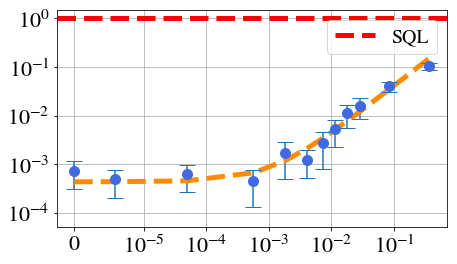

In [112]:
# threshold_list = [1,2,5,10,20,1e2,4e2,1e3,2e3,1e4,4e4,1e5,4e5,1e6,4e6,1e7,4e7,1e8,1e9]
# threshold_list = [1,2,5,10,20,1e2,2e2,4e2,7e2,1e3,2e3,7e3,1e4,2e4,4e4,1e5]
# threshold_list = [500,800,1000,1200,1300,1400,1500,1800,2000,10000]
# threshold_list = [1e5,1e6,1e7,1e8,1e9]
# threshold_list = [1e5]

save_figs = False
figure(figsize = (7,4))
SQL = 1
axhline(SQL, linewidth = 5, linestyle = '--', color = 'red', label = "SQL")

eff_list = []
eff_sigma_list = []

err_list = []
err_sigma_list = []

# threshold_list_temp = threshold_list

for ii in range (len(threshold_list)):

    p1_list = asarray(list(first_count_dict_list[ii].keys()))
    photon_first_count = asarray([x for _,x in sorted(zip(p1_list,first_count_dict_list[ii].values()))])
    num_meas = asarray([x for _,x in sorted(zip(p1_list,meas_num_dict_list[ii].values()))])
    p1_list = sort(p1_list)

    sigma_meas = sqrt(photon_first_count/num_meas*(1-photon_first_count/num_meas) / num_meas)
    sigma_pred = sqrt(p1_list*(1-p1_list)/num_meas)
    
    for ii in range(len(sigma_meas)):
        if sigma_meas[ii] == 0:
            sigma_meas[ii] = sqrt(p1_list[ii]) + 1e-4

    
    fit_start = 0
    fit_stop = -1

    popt, pcov = curve_fit(photon_counter_line, p1_list[fit_start:fit_stop],
                           photon_first_count[fit_start:fit_stop]/num_meas[fit_start:fit_stop], 
                           sigma = sigma_meas[fit_start:fit_stop], bounds = ([0.1,1e-5],[0.75,1e-2]))
    
    plot(p1_list, photon_counter_line(p1_list, *popt),color = 'darkorange', linestyle ='--', linewidth = 5)

    errorbar(p1_list, photon_first_count/num_meas, yerr = sigma_meas, fmt=None, capsize = 8)
    plot(p1_list, photon_first_count/num_meas, 'o', color = 'royalblue', markersize = 10, marker = 'o')

    xscale('symlog', linthreshx = 10**(-5.0))
    yscale('symlog', linthreshy = 10**(-5.0))

#     xlim(1e-5,1)
    ylim(5e-5,1.5)
    
    eff = popt[0]
    eff_list.append(eff)
    eff_sigma_list.append(sqrt(pcov[0][0]))

    
    err = popt[1]
    err_list.append(n_th_fit)
    err_sigma = sqrt(pcov[1][1])
    err_sigma_list.append(err_sigma)
    
print(eff_list)
print(eff_err_list)
print(nth_fit_list)
print(nth_fit_err_list)
    
index = -1
print("threshod = %.2f" %(threshold_list[index]))
print("Background Photon Number: %.6f +/- %.6f" %(n_back[index],n_back_err[index]))
sq_eff = -10*log10(sqrt(n_back[index]))
sq_eff_err = 5/log(10) * 1/n_back[index] * n_back_err[index]
print("Effective Squeezing below Quantum Limit: %.2f +/- %.2f" %(sq_eff,sq_eff_err))

legend(fontsize = 20)
grid()
tight_layout

if save_figs:
    savefig('../figures/photon_counting_1e5.pdf', format='pdf', dpi=1200)

In [108]:
print(photon_first_count)
print(num_meas)

[ 3  3  3  2  2  3  2  3  4  5 16 33]
[4110 6186 4845 4511 1199 2480  747  576  356  320  400  320]


/Users/akashdixit/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:2876: MatplotlibDeprecationWarning: Use of None object as fmt keyword argument to suppress plotting of data values is deprecated since 1.4; use the string "none" instead.
  warnings.warn(msg, mplDeprecation, stacklevel=1)


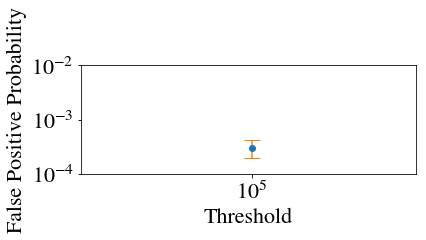

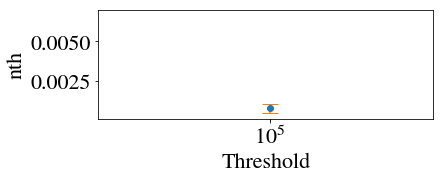

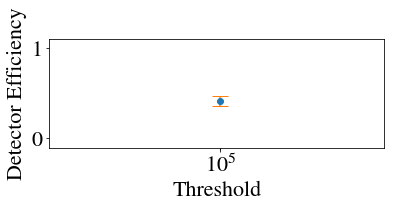

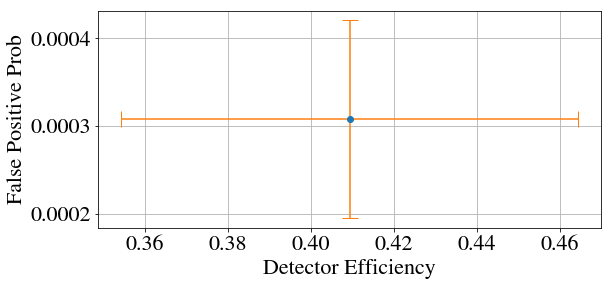

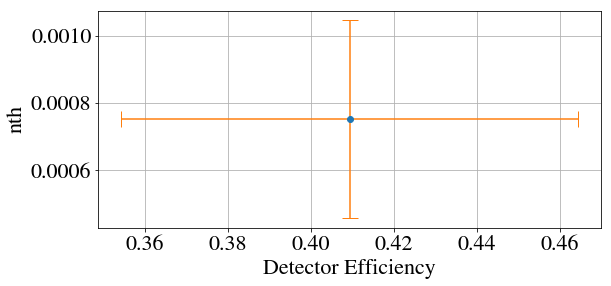

In [109]:
n_back = asarray(err_list)/asarray(eff_list)
n_back_err = sqrt( (1/asarray(eff_list))**2 * (asarray(err_sigma_list))**2 + (asarray(err_list)/(asarray(eff_list))**2)**2 * (asarray(eff_err_list))**2)


# threshold_list = threshold_list_temp

figure(figsize = (6,2))

plot(threshold_list, err_list, 'o')
errorbar(threshold_list, err_list, yerr = err_sigma_list, fmt=None, capsize = 8)
xscale('symlog', linthreshx = 10**(-4.0))
yscale('symlog', linthreshy=10**(-4.0))
xlabel("Threshold")
ylabel("False Positive Probability")
# title("False Positive Probablity")
ylim(1e-4,1e-2)
# grid()
if save_figs:
    savefig('../figures/falseprob_threshold_25meas.pdf', format='pdf', dpi=1200)
    
figure(figsize = (6,2))
plot(threshold_list, n_back, 'o')
errorbar(threshold_list, n_back, yerr = n_back_err, fmt=None, capsize = 8)
xscale('symlog', linthreshx = 10**(-4.0))
# yscale('symlog', linthreshy=10**(-4.0))
ylim(1e-4,7e-3)
# grid()
xlabel("Threshold")
ylabel("nth")
# title("False Positive Probablity")
# grid()
if save_figs:
    savefig('../figures/nth_threshold_25meas.pdf', format='pdf', dpi=1200)
    

    
figure(figsize = (6,2))
plot(threshold_list, eff_list, 'o')
errorbar(threshold_list, eff_list, yerr = eff_sigma_list, fmt=None, capsize = 8)
xscale('symlog', linthreshx = 10**(-4.0))
# yscale('symlog', linthreshy=10**(-4.0))
xlabel("Threshold")
ylabel("Detector Efficiency")
ylim(-0.1,1.1)
# title("False Positive Probablity")
# grid()
if save_figs:
    savefig('../figures/efficiency_threshold_25meas.pdf', format='pdf', dpi=1200)
    
figure(figsize = (9,4))
# plot(eff_list, nth_list, 'o')
# errorbar(eff_list, nth_list, xerr = eff_err_list, yerr = nth_err_list, fmt=None, capsize = 8)
plot(eff_list, err_list, 'o')
errorbar(eff_list, err_list, xerr = eff_sigma_list, yerr = err_sigma_list, fmt=None, capsize = 8)
# xscale('symlog')
# yscale('symlog', linthreshy=10**(-4.0))
# ylim(0.2,0.8)
ylabel("False Positive Prob")
xlabel("Detector Efficiency")
# title("False Positive Probablity")
grid()
if save_figs:
    savefig('../figures/efficiency_fp_25meas.pdf', format='pdf', dpi=1200)
    
figure(figsize = (9,4))

plot(eff_list, n_back, 'o')
errorbar(eff_list, n_back, xerr = eff_sigma_list, yerr = n_back_err, fmt=None, capsize = 8)
# xscale('symlog')
# yscale('symlog', linthreshy=10**(-4.0))
# ylim(0.2,0.8)
ylabel("nth")
xlabel("Detector Efficiency")
# title("False Positive Probablity")
grid()
if save_figs:
    savefig('../figures/efficiency_fp_25meas.pdf', format='pdf', dpi=1200)

Expected Counts 32.903
n_inj: 0.0822568, N: 400.0
Expected Counts 0.036
n_inj: 0.0000058, N: 6186.0


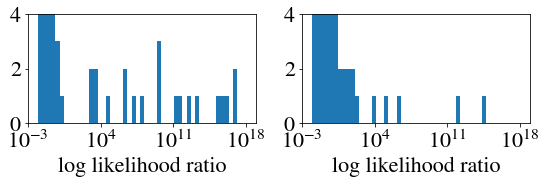

In [110]:
save_figs = False

thresh = 1e4

L_ratio = {}
for p1 in state_dict:
    state_list = state_dict[p1]
    meas_num_dict[p1] = len(state_list)
    first_detected_state_list = []
    L_ratio_list = []
    for ii in range (len(state_list)):
        meas_seq = state_list[ii][start:stop]
        gamma_matrix = gamma(meas_seq, T, E)

        P0 = gamma_matrix[0,0] + gamma_matrix[0,1]
        P1 = gamma_matrix[0,2] + gamma_matrix[0,3]

        # Compare the probabilities of the two models to obtain a likelihood ratio
        likelihood_ratio_first = P1/P0
#         if likelihood_ratio_first > thresh:
        L_ratio_list.append(likelihood_ratio_first)

    L_ratio[p1] = L_ratio_list

for dic in [L_ratio]:
    del dic[2.7708854882465167e-07]
    del dic[0.01228339687027276]
    
figure(figsize = (9,2))
# for p1 in L_ratio.keys():
for ii,p1 in enumerate([0.082256839612458957,5.8268652271955149e-06], start = 1):
    print("Expected Counts %.3f" %(p1*len(L_ratio[p1])))
    print("n_inj: %.7f, N: %.1f" %(p1, len(L_ratio[p1])))
#     axvline(thresh)
#     title("n_inj: %.7f, N: %.1f" %(p1, len(L_ratio[p1])))
    subplot(1,2,ii)
    hist(L_ratio[p1], bins=logspace(-2,18,50))
    xscale('log')
    ylim(0,4)
    xlabel("log likelihood ratio")
#     ylabel("counts")

if save_figs:
    savefig('../figures/hist_nth.pdf', format='pdf', dpi=1200)